## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There is on data files associated with this project:

- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.


In [2]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [3]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# boto3 client to get S3 data
s3_client = boto3.client('s3')
# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [4]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
# print(files)
file_AZDIAS_Feature_Summary = files[0]
file_DIAS_Attributes = files[1]
file_DIAS_Information = files[2]
file_Udacity_AZDIAS_052018 = files[3]
file_Udacity_CUSTOMERS_052018 = files[4]
file_Udacity_MAILOUT_052018_TEST = files[5]
file_Udacity_MAILOUT_052018_TRAIN = files[6]


In [5]:
def load_file(file_name):
    
    # get an S3 object by passing in the bucket and file name
    data_object = s3_client.get_object(Bucket=bucket, Key=file_name)
    
    # information is in the "Body" of the object
    data_body = data_object["Body"].read()
    
    # read in bytes data
    data_stream = io.BytesIO(data_body)
    
    # check file extension 
    if file_name.split(sep='.')[1] == 'xlsx':
        file = pd.read_excel(data_stream, skiprows=0,index_col=0, header=1)
    else:
        file = pd.read_csv(data_stream, sep=';', low_memory=False)
    
    return file

### Step 1: Exploring the Data

In [6]:
# Load Dataframes
Udacity_AZDIAS_052018 = load_file(file_Udacity_AZDIAS_052018)
Udacity_CUSTOMERS_052018 = load_file(file_Udacity_CUSTOMERS_052018)
Feature_Summary = load_file(file_AZDIAS_Feature_Summary)
Dias_Attributes = load_file(file_DIAS_Attributes)
Dias_Info = load_file(file_DIAS_Information)
mailout_train = load_file(file_Udacity_MAILOUT_052018_TRAIN)
mailout_test = load_file(file_Udacity_MAILOUT_052018_TEST)

In [7]:
# Make a copy of the Main dataframe to use
mailout_train_df = mailout_train.copy()
mailout_test_df = mailout_test.copy()

In [8]:
mailout_train_df.shape

(42962, 367)

In [9]:
mailout_test_df.shape

(42833, 366)

In [10]:
# I created a module that has function from the unsupervised stage
import My_Modules as mm

#### Explore Features Summary for AZDIAS_Feature_Summary from the first project in Term 1 with the New dataset

In [11]:
feat_Info = mm.create_new_summary_features(df=Udacity_AZDIAS_052018, df_Att=Dias_Attributes, df_feat_summary=Feature_Summary)

In [12]:
# Features Summary 
feat_Info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [13]:
# Feature Summary for type of data
feat_Info.groupby(['type']).size().reset_index(name='Count')

,type,Count
0,categorical,22
1,interval,1
2,mixed,7
3,numeric,7
4,ordinal,239


In [14]:
# Check shape of new feature summary
feat_Info.shape

(276, 3)

In [15]:
# Check shape of new feature summary
print('\nNew Feat infomation DF',feat_Info.shape)
print('\nOrginal Feat sumarry DF',Feature_Summary.shape)


New Feat infomation DF (276, 3)

Orginal Feat sumarry DF (85, 3)


In [16]:
summary_mail_train_df, cols_to_drop_mail_train = mm.pre_clean_df(Dias_Info=Dias_Info, df=mailout_train_df, feat_Info=feat_Info)
summary_mail_test_df, cols_to_drop_mail_test = mm.pre_clean_df(Dias_Info=Dias_Info, df=mailout_test_df, feat_Info=feat_Info)

In [17]:
# Show attributes of values in Mailout_Train
summary_mail_train_df.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [18]:
# Check shape of feature summary for Mail_train
summary_mail_train_df.shape

(365, 3)

In [19]:
# Check columns to drop for Mail_train Not foud of Dias Attributes
cols_to_drop_mail_train

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [20]:
# Show attributes of values in Mail_test
summary_mail_test_df.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [21]:
# Check shape of feature summary for Mail_test
summary_mail_test_df.shape

(364, 3)

In [22]:
# Check columns to drop for Mail_test Not foud of Dias Attributes
cols_to_drop_mail_test 

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [23]:
# Convert DF to np.NaN Values from Unkown or missing valus from the Features Summary 


mailout_train_df = mm.convert_missing_Unknown_to_Nan(cols_to_drop = cols_to_drop_mail_train, 
                                                     df = mailout_train_df, 
                                                     summary_feat_df = summary_mail_train_df)
mailout_test_df = mm.convert_missing_Unknown_to_Nan(cols_to_drop = cols_to_drop_mail_test, 
                                                    df = mailout_test_df, 
                                                    summary_feat_df = summary_mail_test_df)

In [24]:
# Check for NaN values in Df
mailout_train_df.isna().sum(axis=1).describe()

count    42962.000000
mean        51.250361
std         93.644737
min          0.000000
25%          4.000000
50%          5.000000
75%          8.000000
max        251.000000
dtype: float64

In [25]:
mailout_test_df.isna().sum(axis=1).describe()

count    42833.000000
mean        50.699321
std         93.154546
min          0.000000
25%          4.000000
50%          5.000000
75%          8.000000
max        258.000000
dtype: float64

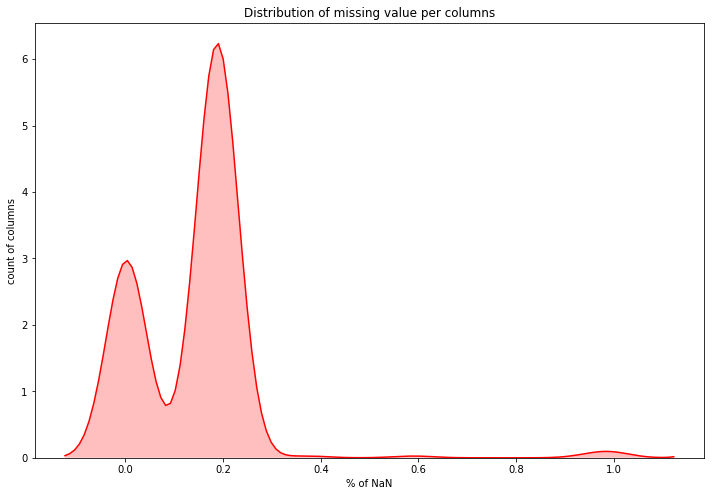

In [26]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# proportion in % of NaN values
count_nan_col = mailout_train_df.isna().sum() / len(mailout_train_df)

# Plot the propotion
fig = plt.figure(figsize=(12,8))
sns.kdeplot(count_nan_col.values,shade=True, color="r")
plt.ylabel('count of columns')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per columns')
plt.show()

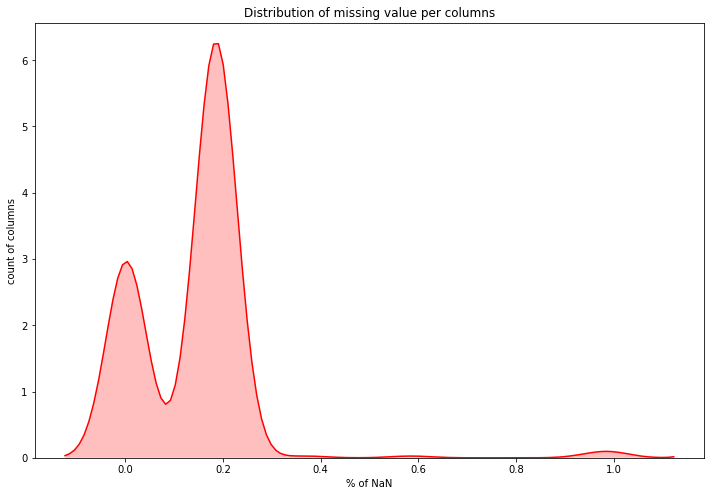

In [27]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# proportion in % of NaN values
count_nan_col = mailout_test_df.isna().sum() / len(mailout_test_df)

# Plot the propotion
fig = plt.figure(figsize=(12,8))
sns.kdeplot(count_nan_col.values,shade=True, color="r")
plt.ylabel('count of columns')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per columns')
plt.show()

### Re-Encode Features

In [28]:
# Check the type of features are found in Mail_Train df
feat_train_df = summary_mail_train_df[summary_mail_train_df['attribute'].isin(mailout_train_df.columns)]
feat_train_df.type.value_counts()

ordinal        239
numeric         96
categorical     22
mixed            7
interval         1
Name: type, dtype: int64

In [29]:
# Check the type of features are found in Mail_Test df
feat_test_df = summary_mail_test_df[summary_mail_test_df['attribute'].isin(mailout_test_df.columns)]
feat_test_df.type.value_counts()

ordinal        239
numeric         95
categorical     22
mixed            7
interval         1
Name: type, dtype: int64

In [30]:
# Create variable to store the differnt type of Categorys
binary_str_attribute, binary_num_attribute, multi_level_attribute = mm.get_categorical_feat(df=mailout_train_df, 
                                                                                            feat_df=feat_train_df)
binary_str_attribute, binary_num_attribute, multi_level_attribute = mm.get_categorical_feat(df=mailout_test_df, 
                                                                                            feat_df=feat_test_df)

In [31]:
# Re encode Multi_level_attribute column:
mailout_train_df = mm.encode_cat(df=mailout_train_df, feature=multi_level_attribute)
mailout_test_df = mm.encode_cat(df=mailout_test_df, feature=multi_level_attribute)

In [32]:
# Create a cleaned DF
clean_mailout_train = mm.clean_data(mailout_train_df)
clean_mailout_test = mm.clean_data(mailout_test_df)

In [33]:
# Check shape 
clean_mailout_train.shape

(42962, 510)

In [34]:
# Check shape
clean_mailout_test.shape

(42833, 509)

In [35]:
# Check Count for Response column in Mailout_Train
num_rows = clean_mailout_train.shape[0]

# Response values
cout = clean_mailout_train.RESPONSE.value_counts(dropna=False)
df_sp = pd.DataFrame({'RESPONSE': cout.index, '% of data': cout.values})
df_sp['% of data'] = 100 * df_sp['% of data'] / num_rows

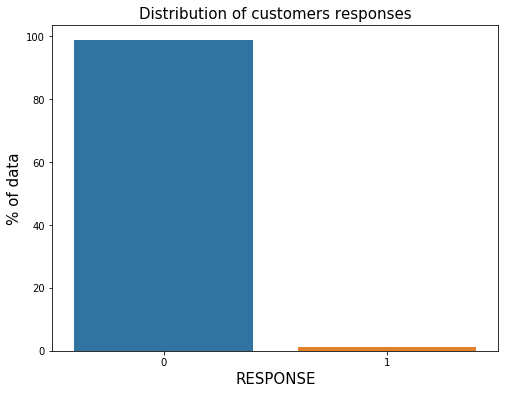

In [36]:
# Show data on Response values

plt.figure(figsize=(8, 6))
sns.barplot(x="RESPONSE", y="% of data", data=df_sp)
plt.rc('xtick', labelsize=25)  
plt.rc('ytick', labelsize=25)
plt.xlabel('RESPONSE', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Distribution of customers responses', fontsize=15)
plt.show()

In [37]:
# Response values
clean_mailout_train.RESPONSE.value_counts(dropna=False)

0    42430
1      532
Name: RESPONSE, dtype: int64

### Step 2: Preparing the Data

In [38]:
# Remove Response from Mailout_Train
# We shall return later
clean_mailout_train.drop(labels='RESPONSE',axis=1, inplace=True)

In [39]:
clean_mailout_train.shape

(42962, 509)

In [40]:
# Sort Index 
clean_mailout_train = clean_mailout_train.sort_values('LNR')
clean_mailout_test = clean_mailout_test.sort_values('LNR')

In [41]:
# Set LNR columns as index
clean_mailout_train = clean_mailout_train.set_index('LNR')
clean_mailout_test = clean_mailout_test.set_index('LNR')

In [42]:
clean_mailout_train.shape

(42962, 508)

In [43]:
clean_mailout_test.shape

(42833, 508)

In [44]:
# Drop NaN
clean_mailout_train.dropna(axis=1, inplace=True)

In [45]:
# Drop NaN
clean_mailout_test.dropna(axis=1, inplace=True)

In [46]:
clean_mailout_train.shape

(42962, 254)

In [47]:
clean_mailout_test.shape

(42833, 254)

In [48]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.NaN, strategy='median')
imp = imp.fit(clean_mailout_train)
imp_mail = imp.transform(clean_mailout_train)

In [49]:
imp_mail.shape

(42962, 254)

In [50]:
new_mailout = pd.DataFrame(imp_mail, columns=clean_mailout_train.columns)
new_mailout.describe()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
count,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,...,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,0.418114,0.021577,0.214818,0.290257,0.055235,0.155277,0.298240,0.101089,0.140217,0.094898,...,0.264001,0.106117,0.048392,0.212374,0.011173,0.567455,0.066268,0.046576,0.048950,0.080979
std,0.493255,0.145300,0.410701,0.453886,0.228441,0.362173,0.457491,0.301450,0.347216,0.293077,...,0.440805,0.307991,0.214595,0.408993,0.105110,0.495435,0.248753,0.210731,0.215767,0.272805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# store them in this dataframe
mailout_scaled=pd.DataFrame(scaler.fit_transform(new_mailout.astype(float)))

# get same features and indices
mailout_scaled.columns = clean_mailout_train.columns
mailout_scaled.index = clean_mailout_train.index

In [52]:
mailout_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 1 to 85795
Columns: 254 entries, AGER_TYP_-1 to PLZ8_BAUMAX_5.0
dtypes: float64(254)
memory usage: 83.6 MB


In [53]:
mailout_scaled.shape

(42962, 254)

In [54]:
mailout_scaled.head()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
LNR,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [55]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.NaN, strategy='median')
imp = imp.fit(clean_mailout_test)
imp_mail = imp.transform(clean_mailout_test)

In [56]:
new_mailout_test = pd.DataFrame(imp_mail, columns = clean_mailout_test.columns)
new_mailout_test.describe()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
count,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,...,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000
mean,0.420167,0.021666,0.215605,0.285691,0.056872,0.150865,0.296897,0.106880,0.144141,0.095254,...,0.262928,0.106507,0.047907,0.218080,0.011440,0.568697,0.066304,0.047067,0.050522,0.079612
std,0.493591,0.145591,0.411246,0.451748,0.231601,0.357921,0.456896,0.308964,0.351237,0.293568,...,0.440229,0.308489,0.213572,0.412947,0.106345,0.495264,0.248816,0.211784,0.219022,0.270694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# store them in this dataframe
test_mailout_scaled=pd.DataFrame(scaler.fit_transform(new_mailout_test.astype(float)))

# get same features and indices
test_mailout_scaled.columns = clean_mailout_test.columns
test_mailout_scaled.index = clean_mailout_test.index

In [58]:
test_mailout_scaled.head()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
LNR,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 3: Features Reduction using PCA and Kmeans

In [59]:
# Apply PCA to the Mailout Train Data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(mailout_scaled)
X_pca = pca.transform(mailout_scaled)

In [60]:
'{:0.2f}'.format(pca.explained_variance_ratio_.sum())

'1.00'

In [61]:
#components_to_retain

variance_total = 0
components_to_retain = -1
for i, v in enumerate(pca.explained_variance_ratio_):
    variance_total += v
    if variance_total >= 0.99:
        components_to_retain = i
        break


print('components_to_retain number is', components_to_retain) 

components_to_retain number is 171


In [62]:
# Re-apply PCA to the data while selecting for number of components to retain.
def dim_reduction(df, pca):
    '''Reduce dimensionality of data using pca decomposition.
       :param df: Normalized customer dataframe; 
       :param pca: principal component analysis.
       return transformed dataframe and pca model
       '''
    
    min_features = 171
    pca = pca(n_components = min_features)
    pca.fit(df)
    reduced = pca.transform(df)
    columns = ['c_{}'.format(i) for i in range(min_features)]
    labels = pd.DataFrame(data=reduced, columns=columns, index=df.index)
    varianace = pca.explained_variance_ratio_.sum()
    print ('The dataframe has {} features and it is transformed to {} with an Explained varainace ration of {:0.2f}'.format(df.shape[1],
                                                                                                                    min_features,
                                                                                                                    varianace))
    
    return pca, reduced, labels

In [63]:
pca, pca_mail_train, reduced_train_feat = dim_reduction(mailout_scaled, pca=PCA)

The dataframe has 254 features and it is transformed to 171 with an Explained varainace ration of 0.99


In [64]:
reduced_train_feat.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_161,c_162,c_163,c_164,c_165,c_166,c_167,c_168,c_169,c_170
LNR,,,,,,,,,,,,,,,,,,,,,
1,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,0.008982,-0.002708,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428
5,3.965506,0.756214,-0.215994,0.139012,-0.094574,-0.246466,-0.285659,-0.134052,0.035218,-0.240467,...,-0.022743,0.007306,0.004818,-0.005299,-0.008679,-0.014131,-0.001534,0.002687,-0.007753,0.000538
9,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,0.008982,-0.002708,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428
10,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,0.008982,-0.002708,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428
11,-0.371718,0.662183,0.634610,-0.667506,0.424038,0.379813,-0.116709,0.208385,0.038237,1.432644,...,0.071073,0.207477,0.207958,0.237362,-0.014618,0.084339,-0.304863,-0.168623,0.086002,0.090619


In [65]:
reduced_train_feat.shape

(42962, 171)

#### 
Determining the optimal number of clusters for k-means clustering For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [66]:
from sklearn.cluster import KMeans

In [67]:
%%time
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    print ('Training k={}...'.format(k))
    km = km.fit(reduced_train_feat)
    Sum_of_squared_distances.append(km.inertia_)

Training k=1...
Training k=2...
Training k=3...
Training k=4...
Training k=5...
Training k=6...
Training k=7...
Training k=8...
Training k=9...
Training k=10...
Training k=11...
Training k=12...
Training k=13...
Training k=14...
CPU times: user 3min 54s, sys: 1min 22s, total: 5min 17s
Wall time: 2min 27s


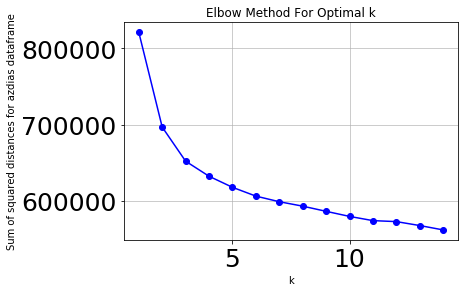

In [68]:
plt.plot(K, Sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances for azdias dataframe')
plt.title('Elbow Method For Optimal k')
plt.grid(alpha=0.8)
plt.show()

In the plot above the elbow is at k=3 indicating the optimal k for this dataset is between 4 and 6.

In [69]:
km = KMeans(n_clusters=2, random_state=42)

In [70]:
km_mailout_train = km.fit(reduced_train_feat)

In [71]:
# Cluster predictions
reduced_train_feat['Cluster'] = km_mailout_train.predict(reduced_train_feat)


In [72]:
# Sort datas according to LNR column
mailout_train_df2 = mailout_train.sort_values('LNR')
mailout_test_df2 = mailout_test.sort_values('LNR')
# Set LNR columns as index
mailout_train_df2 = mailout_train_df2.set_index('LNR')
mailout_test_df2 = mailout_test_df2.set_index('LNR')

In [73]:
# Regrouping Labels and Clusters

reduced = reduced_train_feat.reset_index(drop=True)
response = mailout_train_df2[['RESPONSE']].reset_index(drop=True)['RESPONSE']

In [74]:
concat_train = pd.concat([reduced,response], axis=1)
concat_train.head(10)

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_163,c_164,c_165,c_166,c_167,c_168,c_169,c_170,Cluster,RESPONSE
0,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428,1,0
1,3.965506,0.756214,-0.215994,0.139012,-0.094574,-0.246466,-0.285659,-0.134052,0.035218,-0.240467,...,0.004818,-0.005299,-0.008679,-0.014131,-0.001534,0.002687,-0.007753,0.000538,1,0
2,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428,1,0
3,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428,1,0
4,-0.371718,0.662183,0.634610,-0.667506,0.424038,0.379813,-0.116709,0.208385,0.038237,1.432644,...,0.207958,0.237362,-0.014618,0.084339,-0.304863,-0.168623,0.086002,0.090619,0,0
5,4.001668,0.670727,0.111995,-0.249930,-0.104583,-0.144757,-0.237832,-0.038174,0.037373,-0.143692,...,-0.000799,0.003958,0.002754,0.007063,0.000468,-0.002932,0.006747,0.002734,1,0
6,-0.671242,-1.263836,-0.042865,-1.277574,-0.197724,-1.259248,-0.493178,0.494255,0.881933,0.960259,...,0.015698,-0.064484,0.002841,0.051359,0.041227,0.022407,0.030325,-0.008696,0,0
7,-1.141417,0.671488,0.773434,-0.856306,0.274509,-0.964652,-1.334035,0.633331,0.261465,0.587383,...,0.209092,-0.133912,0.289421,-0.304871,-0.352826,0.400449,-0.471055,-0.033719,0,0
8,4.001668,0.670727,0.111995,-0.249930,-0.104583,-0.144757,-0.237832,-0.038174,0.037373,-0.143692,...,-0.000799,0.003958,0.002754,0.007063,0.000468,-0.002932,0.006747,0.002734,1,0
9,3.965506,0.756214,-0.215994,0.139012,-0.094574,-0.246466,-0.285659,-0.134052,0.035218,-0.240467,...,0.004818,-0.005299,-0.008679,-0.014131,-0.001534,0.002687,-0.007753,0.000538,1,0


In [75]:
# Cluster count for label 0
concat_train[concat_train['RESPONSE']==0]['Cluster'].value_counts()

0    35481
1     6949
Name: Cluster, dtype: int64

In [76]:
# Cluster count for label 1
concat_train[concat_train['RESPONSE']==1]['Cluster'].value_counts()

0    448
1     84
Name: Cluster, dtype: int64

#### 
Do PCA and Kmeans on Mailout_Test

In [77]:
pca, pca_mail_train, reduced_test_feat = dim_reduction(test_mailout_scaled, pca=PCA)

The dataframe has 254 features and it is transformed to 171 with an Explained varainace ration of 0.99


In [78]:
# Mail_Test PCA features
reduced_test_feat.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_161,c_162,c_163,c_164,c_165,c_166,c_167,c_168,c_169,c_170
LNR,,,,,,,,,,,,,,,,,,,,,
2,4.002040,0.695311,0.141709,-0.248340,-0.078177,-0.186636,-0.228007,-0.041814,0.040093,-0.150729,...,-0.000523,0.004408,0.001269,0.000247,0.002129,-0.001138,0.002794,-0.000291,-0.002183,-0.001786
3,4.007755,0.700742,0.142745,-0.246705,-0.077638,-0.182470,-0.227757,-0.039235,0.042738,-0.147917,...,-0.001747,0.006284,0.000594,0.000593,0.002572,0.000294,0.005014,0.000863,0.000494,-0.004118
4,3.996326,0.689880,0.140674,-0.249976,-0.078717,-0.190801,-0.228257,-0.044394,0.037447,-0.153542,...,0.000701,0.002532,0.001945,-0.000099,0.001686,-0.002570,0.000575,-0.001445,-0.004861,0.000547
6,3.970465,0.785248,-0.197447,0.129687,-0.091095,-0.286309,-0.271982,-0.127985,0.030960,-0.250130,...,0.002012,-0.009860,-0.005456,0.001577,-0.004599,0.001026,-0.008058,-0.003908,0.000954,0.007000
7,3.996326,0.689880,0.140674,-0.249976,-0.078717,-0.190801,-0.228257,-0.044394,0.037447,-0.153542,...,0.000701,0.002532,0.001945,-0.000099,0.001686,-0.002570,0.000575,-0.001445,-0.004861,0.000547


In [79]:
reduced_test_feat.shape

(42833, 171)

In [80]:
# reduced_test_feat.to_csv('reduced_mailout_test.csv')

### Step 4: Split the Mail_Train to train/test datesets

In [81]:
# split data into features and labels
labels = mailout_train_df2['RESPONSE']
features = reduced_train_feat.drop('Cluster', axis=1)

# Unbalanced dataset for reduced test features
mail_df = pd.concat([pd.DataFrame(features), pd.DataFrame(labels)], axis=1)
mail_df.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_162,c_163,c_164,c_165,c_166,c_167,c_168,c_169,c_170,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,
1,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,-0.002708,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428,0
5,3.965506,0.756214,-0.215994,0.139012,-0.094574,-0.246466,-0.285659,-0.134052,0.035218,-0.240467,...,0.007306,0.004818,-0.005299,-0.008679,-0.014131,-0.001534,0.002687,-0.007753,0.000538,0
9,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,-0.002708,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428,0
10,3.995876,0.665244,0.110896,-0.251562,-0.105309,-0.148803,-0.238394,-0.040665,0.035157,-0.146415,...,-0.002708,0.000419,0.002900,0.001517,0.005555,0.000531,-0.002683,0.002404,0.000428,0
11,-0.371718,0.662183,0.634610,-0.667506,0.424038,0.379813,-0.116709,0.208385,0.038237,1.432644,...,0.207477,0.207958,0.237362,-0.014618,0.084339,-0.304863,-0.168623,0.086002,0.090619,0


In [82]:
# Check Count for Response column in Mailout_Train
num_rows = clean_mailout_train.shape[0]

# Response values
cout = labels.value_counts()
df_sp = pd.DataFrame({'RESPONSE': cout.index, '% of data': cout.values})
df_sp['% of data'] = 100 * df_sp['% of data'] / num_rows

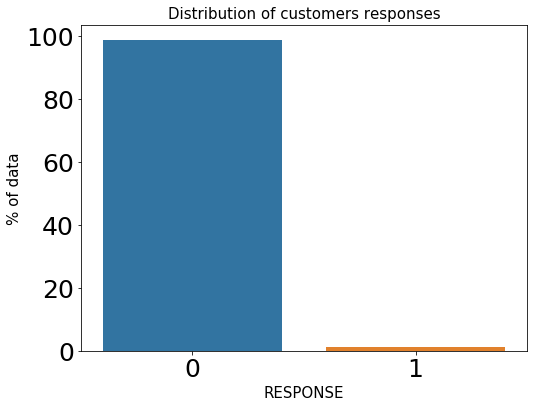

In [83]:
# Show data on Response values

plt.figure(figsize=(8, 6))
sns.barplot(x="RESPONSE", y="% of data", data=df_sp)
plt.rc('xtick', labelsize=25)  
plt.rc('ytick', labelsize=25)
plt.xlabel('RESPONSE', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Distribution of customers responses', fontsize=15)
plt.show()

In [84]:
# Ratio Calculation
positive_response_ratio = labels.value_counts()[1]/labels.value_counts()[0]
print ('The positive response to mail campaign ratio is {:.2f}'.format(positive_response_ratio))

The positive response to mail campaign ratio is 0.01


In [85]:
# shape of the dataset
# print('Shape of training data :', mail_df.shape)
# print('Shape of testing data :', reduced_test_feat.shape)
# print('Shape of y_pridict data :', y_feat.shape) 

In [86]:
# train_df = mail_df.values.astype('float32')
# train_df.shape

In [87]:
# Resize the test_x dataset
# train_df.resize((42833, 172),refcheck=False)

In [88]:
# shape of the dataset
# print('Shape of training data :', train_df.shape)
# print('Shape of testing data :', reduced_test_feat.shape)

In [89]:
# split into train/test
def train_test_split(transaction_df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in transaction_df) from the features.
       :param df: Dataframe of all mailout data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # convert the df into a matrix for ease of splitting
    df_matrix = transaction_df.values
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    # split the data
    train_size = int(df_matrix.shape[0] * train_frac)
    # features are all but last column
    train_features  = df_matrix[:train_size, :-1]
    # class labels *are* last column
    train_labels = df_matrix[:train_size, -1]
    # test data
    test_features = df_matrix[train_size:, :-1]
    test_labels = df_matrix[train_size:, -1]
    
    return (train_features, train_labels), (test_features, test_labels)

In [90]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(mail_df, train_frac=0.7)

In [91]:
# convert features/labels to numpy
train_x_np = train_features.astype('float32')
train_y_np = train_labels.astype('float32')
test_x_np = test_features.astype('float32')
test_y_np = test_labels.astype('float32')

In [92]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in test_features]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals (rows)'], colnames=['predictions (cols)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [93]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

## Improvement: Managing Class Imbalance

We have a model that is tuned to get a higher recall, which aims to reduce the number of false negatives. Earlier, we discussed how class imbalance may actually bias our model towards predicting that all transactions are valid, resulting in higher false negatives and true negatives. It stands to reason that this model could be further improved if we account for this imbalance.

To account for class imbalance during training of a binary classifier, LinearLearner offers the hyperparameter, `positive_example_weight_mult`, which is the weight assigned to positive (1, fraudulent) examples when training a binary classifier. The weight of negative examples (0, valid) is fixed at 1. 

In [94]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, make_scorer

In [95]:
# import LinearLearner
from sagemaker import LinearLearner
from sagemaker.amazon.amazon_estimator import get_image_uri

# container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')
# specify an output path
prefix = 'Capstone'
output_path = 's3://{}/{}'.format(bucket, prefix)

In [96]:
# instantiate a LinearLearner to target_precision

# include params for tuning for higher recall
# *and* account for class imbalance in training data
linear_precision = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_path,
                                sagemaker_session=sagemaker_session,
                                epochs=15,
                                binary_classifier_model_selection_criteria='precision_at_target_recall',
                                target_recall = 0.9,
                                positive_example_weight_mult='balanced')



# create RecordSet
formatted_train_data = linear_precision.record_set(train_x_np, labels=train_y_np)

In [97]:
%%time 
# train the estimator on formatted training data
linear_precision.fit(formatted_train_data)

2020-03-10 06:45:24 Starting - Starting the training job...
2020-03-10 06:45:28 Starting - Launching requested ML instances......
2020-03-10 06:46:34 Starting - Preparing the instances for training.........
2020-03-10 06:48:21 Downloading - Downloading input data
2020-03-10 06:48:21 Training - Downloading the training image...
2020-03-10 06:48:40 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[03/10/2020 06:48:44 INFO 139923327719232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u

In [98]:
%%time 
# deploy and create a predictor
precision_predictor = linear_precision.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 232 ms, sys: 24 ms, total: 256 ms
Wall time: 7min 32s


In [99]:
# test one prediction
result = precision_predictor.predict(test_x_np[12])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.7745776772499084
    }
  }
}
]


In [100]:
print('Metrics for balanced(Precision ), LinearLearner.\n')

# get metrics for balanced predictor
metrics = evaluate(precision_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for balanced(Precision ), LinearLearner.

predictions (cols)   0.0   1.0
actuals (rows)                
0.0                 5673  7049
1.0                   36   131

Recall:     0.784
Precision:  0.018
Accuracy:   0.450



In [101]:
test_np = reduced_test_feat.values.astype('float32')

In [102]:
print('Predict Mail_test_out with tuned balanced(Precision )')
prediction_batches = [precision_predictor.predict(batch) for batch in test_np]
test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                             for batch in prediction_batches])

Predict Mail_test_out with tuned balanced(Precision )


In [103]:
# Resize the reduced_test_feat dataset
test_preds.resize((12889,),refcheck=False)

In [104]:
print('Accuracy {:.3%}'.format(accuracy_score(test_y_np, test_preds)))
print('f1_score {:.3%}'.format(f1_score(test_y_np, test_preds)))
print('recall {:.3%}'.format(recall_score(test_y_np, test_preds)))
print('precision {:.3%}'.format(precision_score(test_y_np, test_preds)))

Accuracy 44.68%
f1_score 2.25%
recall 49.10%
precision 1.15%


In [105]:
# delete the predictor endpoint 
# delete_endpoint(precision_predictor)

In [106]:
%%time
# instantiate and train a LinearLearner to target_precision

# include params for tuning for higher precision
# *and* account for class imbalance in training data
linear_recall = LinearLearner(role=role,
                                 train_instance_count=1, 
                                 train_instance_type='ml.c4.xlarge',
                                 predictor_type='binary_classifier', 
                                 output_path=output_path,
                                 sagemaker_session=sagemaker_session,
                                 epochs=20,
                                 binary_classifier_model_selection_criteria='recall_at_target_precision', # target recall
                                 target_precision = 0.9,
                                 positive_example_weight_mult='balanced')


# train the estimator on formatted training data
linear_recall.fit(formatted_train_data)

2020-03-10 07:15:48 Starting - Starting the training job...
2020-03-10 07:15:50 Starting - Launching requested ML instances.........
2020-03-10 07:17:22 Starting - Preparing the instances for training......
2020-03-10 07:18:44 Downloading - Downloading input data
2020-03-10 07:18:44 Training - Downloading the training image...
2020-03-10 07:19:05 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[03/10/2020 07:19:08 INFO 140053260670784] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u

In [107]:
%%time 
# deploy and evaluate a predictor
recall_predictor = linear_recall.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------------!CPU times: user 297 ms, sys: 19.3 ms, total: 316 ms
Wall time: 8min 32s


In [108]:
# # test one prediction
result = recall_predictor.predict(test_x_np[12])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.7745776772499084
    }
  }
}
]


In [109]:
print('Metrics for tuned balanced (recall), LinearLearner.\n')

# get metrics for balanced predictor
metrics = evaluate(recall_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for tuned balanced (recall), LinearLearner.

predictions (cols)   0.0   1.0
actuals (rows)                
0.0                 8068  4654
1.0                   62   105

Recall:     0.629
Precision:  0.022
Accuracy:   0.634



In [110]:
prediction = [recall_predictor.predict(batch) for batch in test_np]
test_preds_recall = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                             for batch in prediction])

In [111]:
test_preds_recall.resize((12889,),refcheck=False)

In [112]:
print('Predict Mail_test_out with tuned balanced (recall)')
print('Accuracy {:.2%}'.format(accuracy_score(test_y_np, test_preds_recall)))
print('f1_score {:.2%}'.format(f1_score(test_y_np, test_preds_recall)))
print('recall {:.2%}'.format(recall_score(test_y_np, test_preds_recall)))
print('precision {:.2%}'.format(precision_score(test_y_np, test_preds_recall)))

Predict Mail_test_out with tuned balanced (recall)
Accuracy 67.79%
f1_score 2.67%
recall 34.13%
precision 1.39%


In [117]:
cnf_matrix = confusion_matrix(test_y_np, test_preds_recall)
cnf_matrix

array([[8680, 4042],
       [ 110,   57]])

In [118]:
print ('True Positive: {}'.format(cnf_matrix[1][1]))
print ('True Negative: {}'.format(cnf_matrix[0][0]))
print ('False Positive: {}'.format(cnf_matrix[0][1]))
print ('False Negative: {}'.format(cnf_matrix[1][0]))

True Positive: 57
True Negative: 8680
False Positive: 4042
False Negative: 110


In [119]:
# delete the predictor endpoint 
# delete_endpoint(recall_predictor)

In [120]:
# test_np = reduced_test_feat.values.astype('float32')

In [121]:
# # Use the balanced predictor optimise for Recall on the Test data
# prediction_batches = [precision_predictor.predict(batch) for batch in test_np]
# test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
#                              for batch in prediction_batches])

In [122]:
# # delete the predictor endpoint 
# delete_endpoint(recall_predictor)

In [123]:
# Label distribution
labels = pd.Series(test_preds_recall.ravel())
labels.value_counts()

0.0    8790
1.0    4099
dtype: int64

In [124]:
# Ratio Calculation
positive_response_ratio = labels.value_counts()[1]/labels.value_counts()[0]
print ('The positive response to mail campaign ratio is {:.2f}'.format(positive_response_ratio))

The positive response to mail campaign ratio is 0.47


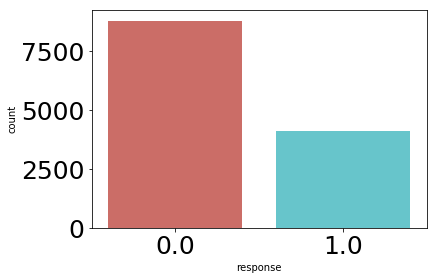

In [125]:
# Count plot of labels
sns.countplot(data=labels, x=labels.index, palette='hls')
plt.xlabel('response')
plt.show()

In [ ]:
# # Deletes a precictor.endpoint
# def delete_endpoint(predictor):
#         try:
#             boto3.client('sagemaker').delete_endpoint(EndpointName=linear_predictor.endpoint)
#             print('Deleted {}'.format(linear_predictor.endpoint))
#         except:
#             print('Already deleted: {}'.format(linear_predictor.endpoint))
            
# delete_endpoint(linear_predictor)

In [ ]:
# # Deleting bucket, uncomment lines below

# bucket_to_delete = boto3.resource('s3').Bucket(bucket)
# bucket_to_delete.objects.all().delete()

In [ ]:
# # Deleting models
# models = client.list_models()
# length_models = len(models['Models'])
# length_training = len(training_jobs['TrainingJobSummaries'])

In [ ]:
# for i in range(length_models):
#     try:
#         client.delete_model(ModelName=models['Models'][i]['ModelName'])
#         print (models['Models'][i]['ModelName'])

In [ ]:
# # deleting bucket, uncomment lines below

# bucket_to_delete = boto3.resource('s3').Bucket(bucket)
# bucket_to_delete.objects.all().delete()